In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
def make_noisy(image, noise_level=1):
    image = image + noise_level * tf.random.normal(mean=0, stddev=1, shape=image.shape, dtype=tf.dtypes.float32)
    image = tf.clip_by_value(image, -1, 1)
    return image

In [ ]:
def pipeline(dataset, batching= True):
    dataset = dataset.map(lambda image: image/128 - 1)
    dataset = dataset.map(lambda image: tf.expand_dims(image, -1))
    dataset = dataset.map(lambda image: (make_noisy(image), image)).cache()
    if batching == True:
      dataset = dataset.shuffle(1000)
      dataset = dataset.batch(32)
      dataset = dataset.prefetch(8)
    return dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = pipeline(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
test_dataset = pipeline(test_dataset)

In [ ]:
# (train_img,train_label), (test_img, test_label) = tf.keras.datasets.mnist.load_data()
# print(train_img.shape)
# print(train_label.shape)
# print(test_img.shape)
# print(test_label.shape)

# train_ds = tf.data.Dataset.from_tensor_slices(train_img)
# test_ds = tf.data.Dataset.from_tensor_slices(test_img)
# print("\nprinting infos after genetaring the data from tensorslicing \n", train_ds, test_ds)

# # for training , data has still the img as data and labels as numbers
# train_ds = train_ds.map(lambda img: (tf.cast(tf.expand_dims(img/255,-1),tf.float32)))
# test_ds = test_ds.map(lambda img: tf.cast(tf.expand_dims(img/255,-1),tf.float32))

# # creating the noise parameters to introduce to the data

# # Create a random noise tensor and add it to the image tensor. You can introduce a
# # hyperparameter to control how noisy your data will be. Make sure to keep the images within
# # the right scale (between 0 and 1)
# # 3You might want to make use of the functions tf.random.normal( ,mean=, stdev=, shape=)
# # and tf.clip by value(, min=, max=)
# shape = (28,28,1)
# noise = tf.random.normal(
#     shape, mean=0.0, stddev=0.3, dtype=tf.float32)


# # tf.random.normal( ,mean=, stdev=, shape=)
# print("noise" , noise.shape, type(noise))


# # for train dataset


# train_ds = train_ds.map(lambda img: tf.math.add(img,noise))

# train_ds = train_ds.map(lambda img: tf.clip_by_value(img, clip_value_min = 0.0, clip_value_max=1.0))

# for eml in train_ds: 
#   print(eml.shape)
#   arr = np.squeeze(eml)
#   plt.imshow(arr)
#   plt.show()
#   break

# # for test dataset

# test_ds = test_ds.map(lambda img: tf.math.add(img,noise))

# test_ds = test_ds.map(lambda img: tf.clip_by_value(img, clip_value_min = 0.0, clip_value_max=1.0))

# for eml in test_ds: 
#   print(eml.shape)
#   arr = np.squeeze(eml)
#   plt.imshow(arr)
#   plt.show()
#   break

#  # creating the pipeline
#  # cache
# train_ds= train_ds.cache()
# test_ds = test_ds.cache() 

#  # shuffel
# train_ds= train_ds.shuffle(1000)
# test_ds = test_ds.shuffle(1000) 

#  # batch 
# train_ds= train_ds.batch(50)
# test_ds = test_ds.batch(50) 

#  # prefetch 
# train_ds= train_ds.prefetch(8)
# test_ds = test_ds.prefetch(8) 
  


# print(train_ds)

                                  







(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)

printing infos after genetaring the data from tensorslicing 
 <TensorSliceDataset shapes: (28, 28), types: tf.uint8> <TensorSliceDataset shapes: (28, 28), types: tf.uint8>


NameError: ignored

 Convolutional Autoencoder


In [ ]:
from tensorflow.keras.layers import Dense,Conv2DTranspose

class Myencoder(tf.keras.Model):
    
    def __init__(self):
        super(Myencoder, self).__init__() # 28x28x1
        self.conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu) # 14x 14x 64
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2) ,strides=(2, 2))# 7 x 7 x 64

        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu) # 14x 14x 64
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2) ,strides=(2, 2))# 7 x 7 x 64

        self.flatten = tf.keras.layers.GlobalAveragePooling2D()

        self.out_encoder = tf.keras.layers.Dense(10,activation=tf.nn.tanh)

    @tf.function
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.max_pool(x)

        x = self.conv_2(x)
        x = self.max_pool_2(x)

        x = self.flatten(x)
        x = self.out_encoder(x)
        return x

In [ ]:
input  = tf.ones((1,28,28,1))
model = Myencoder()
model(input)
model.summary()

Model: "myencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  1280      
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           multiple                  73792     
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                       

In [ ]:
from tensorflow.keras.layers import Dense,Conv2DTranspose

class MyDEcoder(tf.keras.Model):
    
    def __init__(self):
        super(MyDEcoder, self).__init__() # 49x1
        self.dense_1 = tf.keras.layers.Dense(7*7*3)
        self.reshape = tf.keras.layers.Reshape((7,7,3))
        self.transconv_1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2, 2),activation=tf.nn.relu) # 14x14x36
        self.transconv_2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2, 2),activation=tf.nn.relu) # 14x14x36 
 
        self.out_DEcoder = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding="same", activation=tf.nn.tanh)  #28x28x1
        
        

    @tf.function
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.reshape(x)

        x = self.transconv_1(x)
        x = self.transconv_2(x)

        
        x = self.out_DEcoder(x)
        return x

In [ ]:
class CompleteAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(CompleteAutoEncoder, self).__init__()
        
        
        self.encoder = Myencoder()
        
        self.decoder = MyDEcoder()
        
        

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input  = tf.ones((1,49))
model_2 = MyDEcoder()
print(model_2(input).shape)
model_2.summary()

(1, 28, 28, 1)
Model: "my_d_ecoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             multiple                  7350      
                                                                 
 reshape_2 (Reshape)         multiple                  0         
                                                                 
 conv2d_transpose_4 (Conv2DT  multiple                 1664      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  multiple                 32832     
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           multiple                  577       
                                                                 
Total params: 42,423
Trainable params:

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  #test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
   # sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
   # sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
   # test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
 # test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss#, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
# train_dataset = train_dataset.take(1000)
# test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Initialize the model.
model = CompleteAutoEncoder()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []

#testing once before we begin
test_loss = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)

#check how model performs on train data once before we begin
train_loss = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with test loss {test_losses[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)


Epoch: 0 starting with test loss 0.9262027144432068
Epoch: 1 starting with test loss 0.24398545920848846
Epoch: 2 starting with test loss 0.22181732952594757
Epoch: 3 starting with test loss 0.2048383504152298
Epoch: 4 starting with test loss 0.19443568587303162
Epoch: 5 starting with test loss 0.18958722054958344
Epoch: 6 starting with test loss 0.18987281620502472
Epoch: 7 starting with test loss 0.1801229566335678
Epoch: 8 starting with test loss 0.18308623135089874
Epoch: 9 starting with test loss 0.18156808614730835
Epoch: 10 starting with test loss 0.17925989627838135
Epoch: 11 starting with test loss 0.1765272617340088
Epoch: 12 starting with test loss 0.17480111122131348
Epoch: 13 starting with test loss 0.1757226437330246
Epoch: 14 starting with test loss 0.1789248287677765
Epoch: 15 starting with test loss 0.17702707648277283
Epoch: 16 starting with test loss 0.1722611039876938
Epoch: 17 starting with test loss 0.1731410175561905
Epoch: 18 starting with test loss 0.1709647774

train data


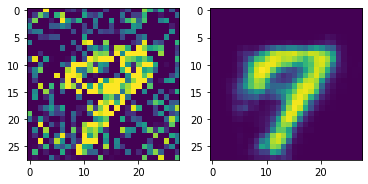

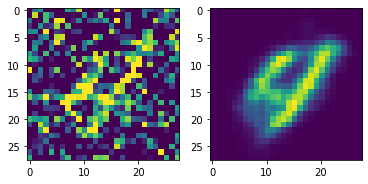

In [ ]:
 def pipeline_viz(image):
    image = image/128 - 1
    image = make_noisy(image)
    image = tf.expand_dims(image, -1)
    image = tf.expand_dims(image, 0)

    return image

image = x_test[9]

noisy = pipeline_viz(image)

denoised = model(noisy)

denoised = tf.squeeze(denoised)

noisy = (tf.squeeze(noisy) + 1) / 2



f, axarr = plt.subplots(1,2)
axarr[0].imshow(noisy)
axarr[1].imshow(denoised)




print("train data")

 def pipeline_viz(image):
    image = image/128 - 1
    image = make_noisy(image)
    image = tf.expand_dims(image, -1)
    image = tf.expand_dims(image, 0)

    return image

image = x_train[9]

noisy = pipeline_viz(image)

denoised = model(noisy)

denoised = tf.squeeze(denoised)

noisy = (tf.squeeze(noisy) + 1) / 2



f, axarr = plt.subplots(1,2)
axarr[0].imshow(noisy)
axarr[1].imshow(denoised)


In [ ]:
print(np.min(image))
print(np.max(image))

0
255


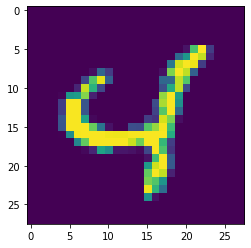

In [ ]:
plt.imshow(image /255)